In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import math


import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.layers import BatchNormalization
from keras import optimizers
from keras.callbacks import LearningRateScheduler



2024-02-20 13:15:16.264735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 13:15:16.264845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 13:15:16.420331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
driver_details = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [ ]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

In [ ]:
# ## getting list of driver names

# D = []
# for features,labels,drivers in train_image:
#     D.append(drivers)

# ## Deduplicating drivers

# deduped = []

# for i in D:
#     if i not in deduped:
#         deduped.append(i)


# ## selecting random drivers for the validation set
# driv_selected = []
# import random
# driv_nums = random.sample(range(len(deduped)), 4)
# for i in driv_nums:
#     driv_selected.append(deduped[i])


In [ ]:
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [ ]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)

    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)

print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [ ]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)


(18732, 224, 224, 3)


In [ ]:
## Defining the input

from keras.layers import Input
resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50


#Get the RESNET weights and layers

model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_resnet50_conv.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
#Use the generated model
from keras.models import Model


output_resnet50_conv = model_resnet50_conv(resnet50_input)

#Add the fully-connected layers

x = Flatten(name='flatten')(output_resnet50_conv)

x = Dense(10, activation='softmax', name='predictions')(x)


resnet50_pretrained = Model(inputs=resnet50_input, outputs=x)



resnet50_pretrained.summary()

# Compile CNN model

sgd = optimizers.SGD(lr = 0.001)


resnet50_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 predictions (Dense)         (None, 10)                1003530   
                                                                 
Total params: 24591242 (93.81 MB)
Trainable params: 24538122 (93.61 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('resnet_weights_aug_alltrained_sgd2_setval.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
resnet50_model = resnet50_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper,lrate],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/25


I0000 00:00:1708435357.930443     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


293/292 [==============================] - ETA: 0s - loss: 2.5881 - accuracy: 0.3492
Epoch 1: val_loss improved from inf to 1.77844, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
292/292 [==============================] - 240s 728ms/step - loss: 2.5881 - accuracy: 0.3492 - val_loss: 1.7784 - val_accuracy: 0.5561 - lr: 0.0010
Epoch 2/25
293/292 [==============================] - ETA: 0s - loss: 1.3846 - accuracy: 0.5976
Epoch 2: val_loss improved from 1.77844 to 0.94532, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
292/292 [==============================] - 205s 699ms/step - loss: 1.3846 - accuracy: 0.5976 - val_loss: 0.9453 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 3/25
293/292 [==============================] - ETA: 0s - loss: 1.0539 - accuracy: 0.6824
Epoch 3: val_loss did not improve from 0.94532
292/292 [==============================] - 204s 694ms/step - loss: 1.0539 - accuracy: 0.6824 - val_loss: 1.0963 - val_accuracy: 0.7914 - lr: 0.0010
Epoch 

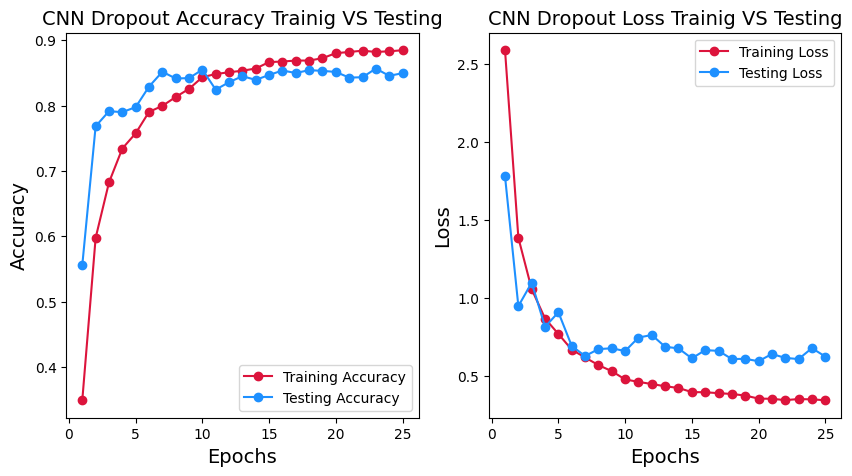

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(resnet50_pretrained.history.history['accuracy']) + 1), resnet50_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(resnet50_pretrained.history.history['val_accuracy']) + 1), resnet50_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['loss']) + 1), resnet50_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['val_loss']) + 1), resnet50_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [ ]:
resnet50_pretrained.history.history['accuracy'][:5]

[0.34918856620788574,
 0.597586989402771,
 0.6824151277542114,
 0.7343583106994629,
 0.7576339840888977]

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


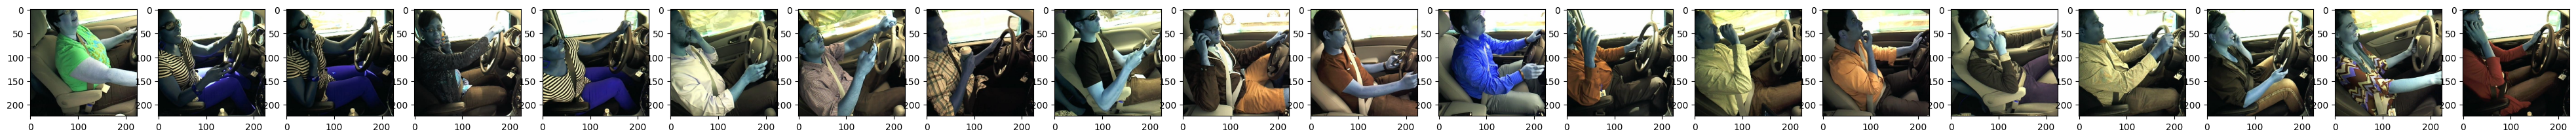

In [ ]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('/kaggle/input/state-farm-distracted-driver-detection/imgs/test')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread('/kaggle/input/state-farm-distracted-driver-detection/imgs/test/'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show


In [ ]:
test = []

for img in test_image:
    test.append(img)

resnet50_pretrained.load_weights('resnet_weights_aug_alltrained_sgd2_setval.hdf5')


test = np.array(test).reshape(-1,224,224,3)
prediction = resnet50_pretrained.predict(test)

1/1 [==============================] - 2s 2s/step


In [ ]:
prediction[0]

array([1.5560704e-03, 3.1669231e-10, 1.1758891e-10, 5.8766263e-06,
       1.1434680e-06, 9.9682391e-01, 1.4424856e-11, 5.3501882e-08,
       3.1626466e-06, 1.6098727e-03], dtype=float32)

In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

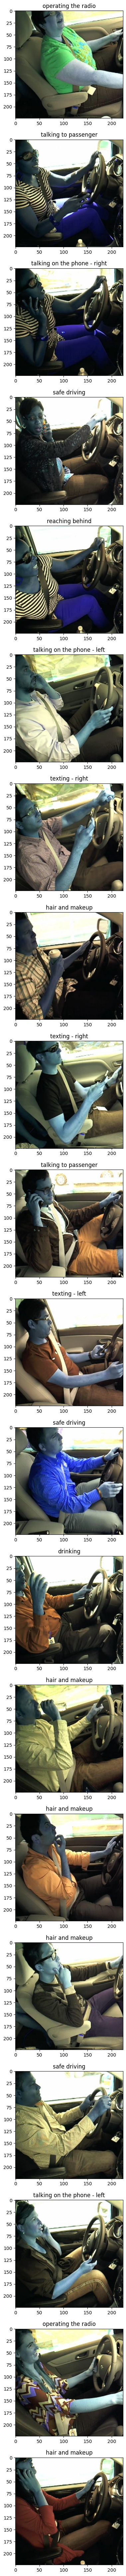

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show

